Retention_Rate Prediction For Video A

In [2]:

import pandas as pd
import matplotlib.pyplot as plt
from docx import Document

Total video length: 765
100
Video retention position is  7.65
Total Words: 2271
Words per second: 2.97
Words per 8.33s segment: 22
Identified Drop-Off Points for Video B:
    Video position (%)  timestamp  \
98                  98     749.70   
99                  99     757.35   

                                       script_segment  \
98  Gary Banning from North Carolina was at his fr...   
99  was hot sauce, and without bothering to check,...   

    Absolute audience retention (%)  
98                            32.85  
99                            20.07  
   Video position (%)  Absolute audience retention (%) video_id  \
0                   0                           103.63        B   
1                   1                            87.91        B   
2                   2                            84.54        B   
3                   3                            81.15        B   
4                   4                            81.26        B   

                            

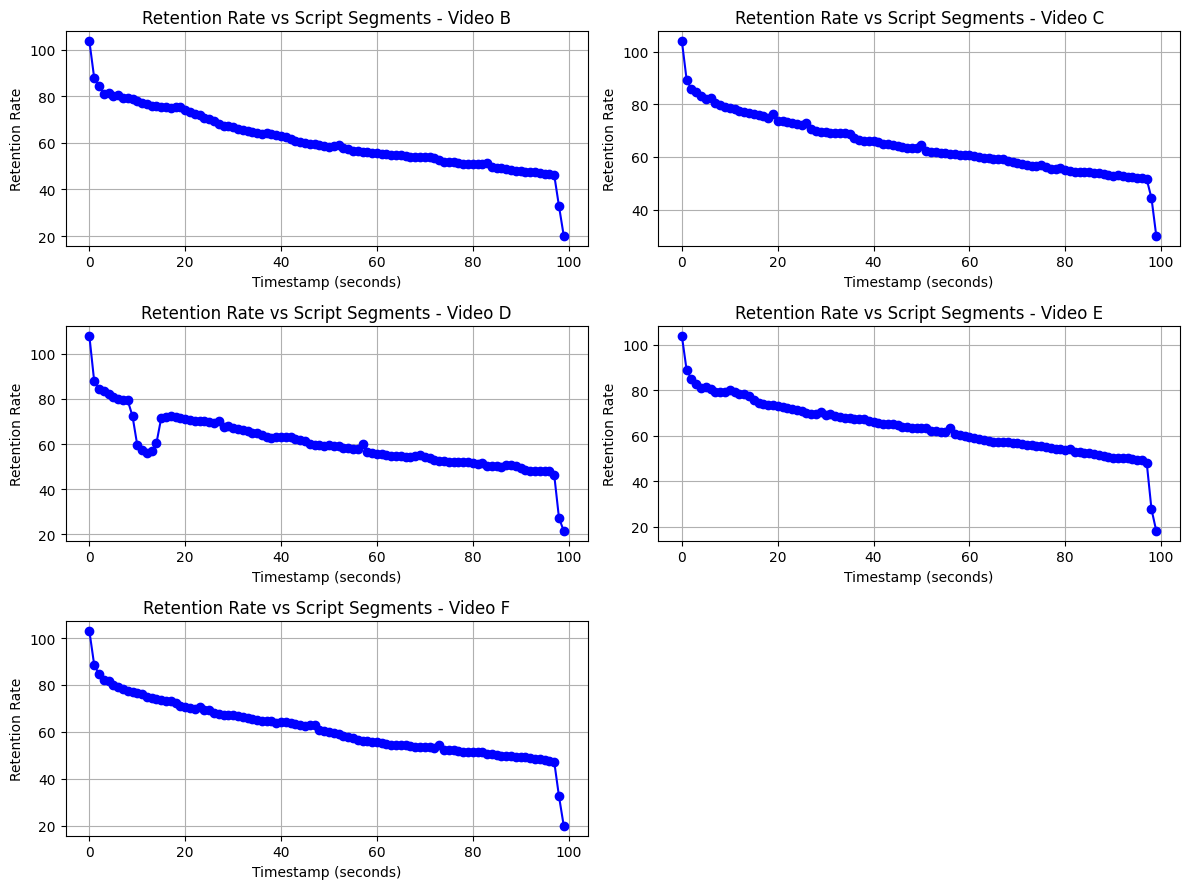

In [ ]:
#Reading the script and the retention data for the  videos and segment the script based on the video position and create a dataset
#for predicting the retention rate with the features namely video position and script segments

import pandas as pd
import matplotlib.pyplot as plt
from docx import Document

#read the script
def read_docx(file_path):
    doc = Document(file_path)
    return "\n".join([para.text for para in doc.paragraphs])

#load the retention data
data = [
    ("B", pd.read_csv("VIDEO B.csv"), read_docx("VIDEO B.docx"), 765),
    ("C", pd.read_csv("VIDEO C.csv"), read_docx("VIDEO C.docx"), 833),
    ("D", pd.read_csv("VIDEO D.csv"), read_docx("VIDEO D.docx"), 822),
    ("E", pd.read_csv("VIDEO E.csv"), read_docx("VIDEO E.docx"), 654),
    ("F", pd.read_csv("VIDEO F.csv"), read_docx("VIDEO F.docx"), 713),    
]

#assigning ncols and nrows for plotting
ncols = 2 
nrows = (len(data) + ncols - 1) // ncols 

#creating subplots to display "the retention vs script segment plots"
fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 3*nrows))
axes = axes.flatten()
full_retention_data = pd.DataFrame()
for i, (vdo, df_retention, script_text, video_length) in enumerate(data):
    #creating column for video id in the dataset
    df_retention["video_id"] = vdo
    vdo_retention_position = (video_length/len(df_retention)) #for exact timestamp

    #for calculating the words/second and segment
    words = script_text.split()  #split script into words
    total_words = len(words)
    words_per_second = total_words / video_length
    words_per_segment = int(words_per_second * vdo_retention_position) 

    print(f"Total video length: {video_length}")
    print(len(df_retention))
    print("Video retention position is ", vdo_retention_position)
    print(f"Total Words: {total_words}")
    print(f"Words per second: {words_per_second:.2f}")
    print(f"Words per 8.33s segment: {words_per_segment}")

    #segment the script for each vdo retention position
    script_segments = [
        " ".join(words[i * words_per_segment:(i + 1) * words_per_segment])
        for i in range(len(df_retention))
    ]

    #if any remaining words, it will be appended to the last segment of the script
    if len(words) % len(df_retention) != 0:
        script_segments[-1] += " " + " ".join(words[len(df_retention) * words_per_segment:])

    #creating script segments column and timestamp column in the dataset
    df_retention["script_segment"] = script_segments
    df_retention["timestamp"] = df_retention["Video position (%)"] * vdo_retention_position
        
    #setting threshold for retention rate drop
    drop_off_threshold = 40.00 
    #find sections where retention drops significantly
    drop_points = df_retention[df_retention['Absolute audience retention (%)'] < drop_off_threshold]
    drop_points_segments = drop_points[['Video position (%)', 'timestamp', 'script_segment', 'Absolute audience retention (%)']]

    print(f"Identified Drop-Off Points for Video {vdo}:")
    print(drop_points_segments)
    print(df_retention.head())
    
    #Plotting the retention rate vs script segments fro visualisation
    axes[i].plot(df_retention['Video position (%)'], df_retention['Absolute audience retention (%)'], marker='o', linestyle='-', color='b')
    axes[i].set_title(f"Retention Rate vs Script Segments - Video {vdo}")
    axes[i].set_xlabel("Timestamp (seconds)")
    axes[i].set_ylabel("Retention Rate")
    axes[i].grid(True)

    #save the file with retention data, script and timestamp with video id
    df_retention.to_csv(f"script_{vdo}_with_retention.csv", index=False)
    full_retention_data = pd.concat([full_retention_data, df_retention], ignore_index=True) #append data for each video

#hide unused axes
for j in range(len(data), len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

#final dataset for training with the data of all videos
full_retention_data.to_csv("full_retention_data_with_video_id.csv", index=False)
# print(df_retention.head())


In [46]:
!pip install gensim

  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
   ---------------------------------------- 0.0/24.0 MB ? eta -:--:--
    --------------------------------------- 0.5/24.0 MB 4.2 MB/s eta 0:00:06
   -- ------------------------------------- 1.3/24.0 MB 4.0 MB/s eta 0:00:06
   --- ------------------------------------ 2.1/24.0 MB 4.5 MB/s eta 0:00:05
   ----- ---------------------------------- 3.4/24.0 MB 4.5 MB/s eta 0:00:05
   ------- -------------------------------- 4.5/24.0 MB 4.6 MB/s eta 0:00:05
   --------- ------------------------------ 5.5/24.0 MB 4.7 MB/s eta 0:00:04
   ----------- ---------------------------- 6.8/24.0 MB 4.9 MB/s eta 0:00:04
   ------------- -------------------------- 8.4/24.0 MB 5.4 MB/s eta 0:00:03
   --------------- ------------------------ 9.4/24.0 MB 5.3 MB/s eta 0:00:03
   ------------------ --------------------- 11.3/24.0 MB 5.6 MB/s eta 0:00:03
   -------------------- ------------------- 12.3/24.0 MB 5.6 MB/s eta 0:00:03
   -------

  You can safely remove it manually.
  You can safely remove it manually.


In [4]:
#training for predicting retention rate

import pandas as pd
import numpy as np
import gensim
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import word_tokenize

#loading the dataset
df_retention = pd.read_csv("full_retention_data_with_video_id.csv")

#tokenizing for word2vec
script_data = []
for script in df_retention['script_segment']:
    tokens = word_tokenize(script.lower())
    script_data.append(tokens)

#word2vec model
word2vec_model = gensim.models.Word2Vec(script_data, min_count=1, vector_size=100, window=5, sg=0)

#function to get the average word vector for a sentence
def get_average_word2vec(text, model, vector_size=100):
    words = text.split() 
    word_vectors = []
    for word in words:
        if word in model.wv: #checking for word in vocabulary
            word_vectors.append(model.wv[word])
    if len(word_vectors) == 0:
        return np.zeros(vector_size)
    return np.mean(word_vectors, axis=0)

#embeddings
df_retention['script_embedding'] = df_retention['script_segment'].apply(lambda x: get_average_word2vec(x, word2vec_model))

#normalixation
scaler = StandardScaler()
df_retention['timestamp_scaled'] = scaler.fit_transform(df_retention[['Video position (%)']])

train_data = df_retention
#features and labels
X_train = np.array([embedding for embedding in train_data['script_embedding']])
X_train = np.column_stack([X_train, df_retention['timestamp_scaled'], df_retention['Compared to other videos (%)']])
y_train = df_retention['Absolute audience retention (%)']
#training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [35]:
#training for predicting Compared to other videos (%)

train_data = df_retention
#features and labels
X_train = np.array([embedding for embedding in train_data['script_embedding']])
X_train = np.column_stack([X_train, df_retention['timestamp_scaled'], df_retention['Absolute audience retention (%)']])
y_train = df_retention['Compared to other videos (%)']
#training
model1 = RandomForestRegressor(n_estimators=100, random_state=42)
model1.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [29]:
#Preparing video A data for inferencing in the trained model for predicting retention rates and Compared to other videos (%) missing rows
#Writing script segments for video A where the timestamp is not provided
#Identify the vdo script length and total timestamps for A

#function for reading docx file
def read_docx(file_path):
    doc = Document(file_path)
    return "\n".join([para.text for para in doc.paragraphs])

#loading retention data and vdo script
df_retention_A = pd.read_csv("Copy of VIDEO A.csv") 
script_text = read_docx("VIDEO A_intro_altered.docx") 
words = script_text.split() 
total_words = len(words)
words_per_segment = int(total_words / 100)

#segment the script for each vdo retention position
script_segments = [
    " ".join(words[i * words_per_segment:(i + 1) * words_per_segment])
    for i in range(len(df_retention_A))
]
if len(words) % len(df_retention_A) != 0:
    script_segments[-1] += " " + " ".join(words[len(df_retention) * words_per_segment:])

#creating script segment column
df_retention_A["script_segment"] = script_segments
df_retention_A.to_csv("vdo_A_with_altered_script_segments.csv", index=False)
print(df_retention_A.head())

   Video position (%)  Absolute audience retention (%)  \
0                   0                              NaN   
1                   1                              NaN   
2                   2                              NaN   
3                   3                              NaN   
4                   4                              NaN   

   Compared to other videos (%)  \
0                           NaN   
1                           NaN   
2                           NaN   
3                           NaN   
4                           NaN   

                                      script_segment  
0  Embarrassingly Dumb Ways People Died [Part 8] ...  
1  down in history for all the wrong reasons. Fro...  
2  exit in ways that are as shocking as they are ...  
3  most Embarrassingly Dumb Ways People Died. Lab...  
4  species, it’s always best to take a few steps ...  


In [30]:

#Embedding the script segment for video A and preparing for inferencing
# df_retention_A = pd.read_csv("script_with_retention_A.csv")
df_retention_A = pd.read_csv("vdo_A_with_altered_script_segments.csv")

script_data = []
for script in df_retention_A['script_segment']:
    tokens = word_tokenize(script.lower())
    script_data.append(tokens)
word2vec_model = gensim.models.Word2Vec(script_data, min_count=1, vector_size=100, window=5, sg=0)

def get_average_word2vec(text, model, vector_size=100):
    words = text.split() 
    word_vectors = []

    for word in words:
        if word in model.wv: 
            word_vectors.append(model.wv[word])
    if len(word_vectors) == 0:
        return np.zeros(vector_size)
    return np.mean(word_vectors, axis=0)


df_retention_A['script_embedding'] = df_retention_A['script_segment'].apply(lambda x: get_average_word2vec(x, word2vec_model))
scaler = StandardScaler()
df_retention_A['timestamp_scaled'] = scaler.fit_transform(df_retention_A[['Video position (%)']])
# print(df_retention_A.shape)


In [26]:
#Predicting retention rates for after and before 6 timestamps for Video A

test_data = df_retention_A[df_retention_A['Video position (%)'] > 6] #leaving first 6 timestamps for Video A
# print(test_data.shape)
X_test = np.array([embedding for embedding in test_data['script_embedding']])
X_test = np.column_stack([X_test, test_data['timestamp_scaled'], test_data['Absolute audience retention (%)']])
y_test = test_data['Absolute audience retention (%)'] 
#Predict retention rates for Video A's afterr 6 timestamps
y_pred = model.predict(X_test)

# #Evaluate model performance on Video A data
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error : {mse}")
# Print predicted retention rates for Video A aftr 6 timestampa
print(f"Predicted Retention Rates for Video A after 6 timestamps :{y_pred}")
# for pred in y_pred:
#     print(f"{pred:.2f}")


#Predicting retention rates for first 6 timestamps for Video A

test_data = df_retention_A[df_retention_A['Video position (%)'] < 6]
# print(test_data.shape)
X_test = np.array([embedding for embedding in test_data['script_embedding']])
X_test = np.column_stack([X_test, test_data['timestamp_scaled'], test_data['Absolute audience retention (%)']])
y_test = test_data['Absolute audience retention (%)'] 

#Predict retention rates for Video A's first 6 timestamps
y_pred = model.predict(X_test)

# Print predicted retention rates for Video A's first 6 timestampa
print(f"Predicted Retention Rates for Video A's first 6 timestamps :")
for pred in y_pred:
    print(f"{pred:.2f}")

Mean Squared Error : 5.0736347730107
Predicted Retention Rates for Video A after 6 timestamps :[79.9739 79.8542 78.2825 75.5648 76.7979 75.6395 75.911  74.5851 73.1056
 72.7818 72.6225 72.3574 71.9367 71.7464 71.8347 70.4762 70.9689 70.764
 70.5377 69.7761 69.2937 68.5988 68.4698 68.6817 68.1384 68.3471 68.1661
 68.0889 68.1141 67.9886 67.8931 67.4068 66.875  66.6611 66.4713 65.8957
 65.06   63.9275 62.8125 61.9216 61.5548 61.7482 61.2226 61.4187 61.3691
 61.0679 61.2328 60.8015 60.7545 60.4474 60.3062 59.6446 59.2817 59.004
 58.8724 58.6014 57.9959 57.6152 57.2511 57.2161 56.7185 56.5041 56.2753
 55.8041 54.9876 54.7531 54.3309 53.9186 53.8657 53.8247 53.6387 53.6414
 53.7918 53.5438 53.6782 53.6157 53.5876 53.6652 53.6417 53.6648 53.5966
 53.5616 53.351  53.4323 53.3981 53.3372 53.4181 53.3522 53.2947 53.3845
 53.1366 37.3849 34.0208]
Predicted Retention Rates for Video A's first 6 timestamps :
98.59
88.45
86.63
83.09
82.11
81.70


In [ ]:
#Predicting Compared to other videos (%) for first 6 timestamps
script_data = []
for script in df_retention_A['script_segment']:
    tokens = word_tokenize(script.lower())  # Tokenize and lowercase
    script_data.append(tokens)

word2vec_model = gensim.models.Word2Vec(script_data, min_count=1, vector_size=100, window=5, sg=0)

def get_average_word2vec(text, model, vector_size=100):
    words = text.split() 
    word_vectors = []

    for word in words:
        if word in model.wv: 
            word_vectors.append(model.wv[word])

    if len(word_vectors) == 0:
        return np.zeros(vector_size)
    return np.mean(word_vectors, axis=0)


df_retention_A['script_embedding'] = df_retention_A['script_segment'].apply(lambda x: get_average_word2vec(x, word2vec_model))


scaler = StandardScaler()
df_retention_A['timestamp_scaled'] = scaler.fit_transform(df_retention_A[['Video position (%)']])

test_data = df_retention_A[df_retention_A['Video position (%)'] < 6]
 
X_test = np.array([embedding for embedding in test_data['script_embedding']])
X_test = np.column_stack([X_test, test_data['timestamp_scaled'], test_data['Absolute audience retention (%)']])
y_test = test_data['Compared to other videos (%)']
#predict retention rates for Video A's first 6 timestamps
y_pred = model1.predict(X_test)
print("Predicted Compared to other videos (%) column for Video A (First 6 timestamps):")
for pred in y_pred:
    print(f"{pred:.2f}")

Predicted Compared to other videos (%) column for Video A (First 6 timestamps):
53.94
56.12
57.91
58.45
56.33
57.25


In [32]:
#Predicting retention rates for first 6 timestamps for Video A with ALtered intro

test_data = df_retention_A[df_retention_A['Video position (%)'] < 6]
# print(test_data.shape)
X_test = np.array([embedding for embedding in test_data['script_embedding']])
X_test = np.column_stack([X_test, test_data['timestamp_scaled'], test_data['Absolute audience retention (%)']])
y_test = test_data['Absolute audience retention (%)'] 

#Predict retention rates for Video A's first 6 timestamps
y_pred = model.predict(X_test)

# Print predicted retention rates for Video A's first 6 timestampa
print(f"Predicted Retention Rates for Video A's first 6 timestamps with altered intro :")
for pred in y_pred:
    print(f"{pred:.2f}")

Predicted Retention Rates for Video A's first 6 timestamps with altered intro :
98.74
88.54
86.72
83.11
82.15
81.68


In [39]:
X_test = np.array([embedding for embedding in test_data['script_embedding']])
X_test = np.column_stack([X_test, test_data['timestamp_scaled'], test_data['Absolute audience retention (%)']])
y_test = test_data['Compared to other videos (%)']
#predict retention rates for Video A's first 6 timestamps
y_pred = model1.predict(X_test)
print("Predicted Compared to other videos (%) column for Video A First 6 timestamps for the altered intro:")
for pred in y_pred:
    print(f"{pred:.2f}")

Predicted Compared to other videos (%) column for Video A First 6 timestamps for the altered intro:
52.77
56.69
57.58
57.87
57.07
57.92
